In [2]:
from collections import defaultdict
import requests
import re
import logging

from tqdm.auto import tqdm
from bs4 import BeautifulSoup, SoupStrainer

with open('../data/textbook-first-pages.txt', 'r') as f:
    textbook_first_pages = f.read().splitlines()

## Class for Scraping OpenStax

We look for all elements that with `data-type` == `'title'`. This includes subsection headers as well as exercise problem titles and information cards.

Ignore exercise problem titles and information cards, which are identified by `id` and `class: ['os-title']`, respectively.

### Assumptions and Shortcuts
 - Ignoring any pages that do not start with digit-dash-digit, so '1-1-introduction' is fine but '1-Introudction' and 'Index' are ignored

### Subsection Header
"Sets of Numbers as Subsets". This is the subsection header that we want.

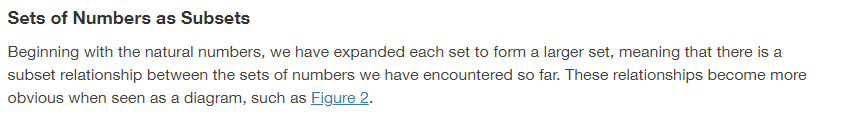

### Exercise problem
The Exercise problem title is "EXAMPLE 5". We do not want to consider this a subsection. We ignore it by looking for titles WITHOUT the `id` tag.

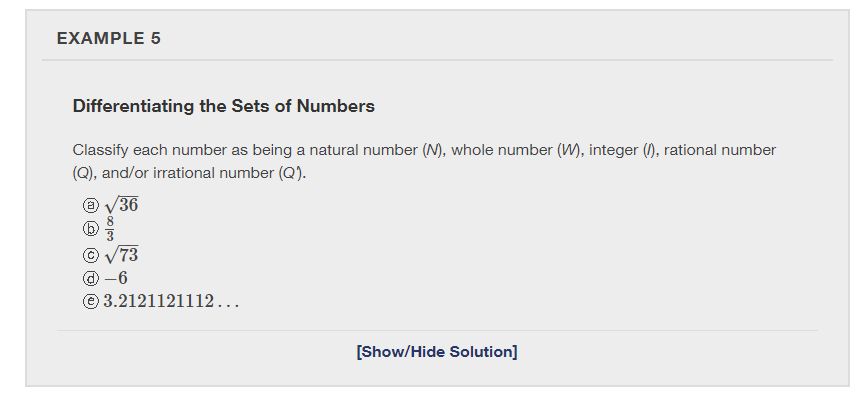

### Information Card
The information card title is "SETS OF NUMBERS". We do not want to consider this a subsection. We ignore it by looking for titles without the `class: ['os-title']` tag.

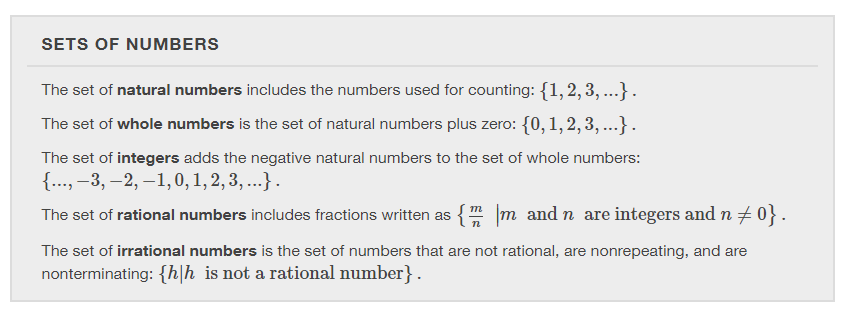


In [3]:
class StaxBook:
    def __init__(self, first_page_url):
        self.first_page_url = first_page_url
        self.base_url = first_page_url.split('/pages/')[0] # a non-functional URL used to build other URLs
        self.title = self.base_url.split('/')[-1]
        self.sections = []
        self.get_section_urls()
        
    def get_section_urls(self):
        soup = BeautifulSoup(requests.get(self.first_page_url).text,
                             features='html.parser')
        
        for a in soup.find_all('a',
                               class_='styled__ContentLink-sc-18yti3s-1 cRIWDW',
                               href=True):
            # matches urls with a chapter-section-title format, like "1-1-what-is-economics"
            # no match for urls with a chapter-title format, like "1-introduction" or "1-keyterms"
            match = re.search(r'^\d+-\d+', a['href'])
            if match:
                self.sections.append({
                    'section': match[0],
                    'url': '/'.join([self.base_url, 'pages', a['href']]),
                })
        
    def scrape_one(self, soup):
        '''Scrape a textbook section page into a dictionary of subsections.
        '''
        # create a list of sub-section headers
        sub_section_headers = list(soup.find_all(attrs={'data-type': 'title', 'id': None, 'class': None}))

        # catch any content that appears before the first header by beginning with a 'no_header' subsection
        sub_section_title = 'no_header'
        sub_section_text = defaultdict(str)
        
        # keep track of sub_section_str_len
        sub_section_str_len = 0

        for e in soup.strings:
            if e.parent in sub_section_headers:
                sub_section_title = e.text
                print(sub_section_title)

                sub_section_str_len = 0
                sub_section_keyterm_spans = []

            if isinstance(e, str) and not e.isspace():
                text = re.sub('\s+', ' ', e.text) + ' ' # add a space at the end of each element
                if e.parent.attrs.get('data-type', None) == 'term':
                    try:
                        keyterm_spans.append((total_str_len,
                                              total_str_len + len(text) - 1, # -1 because we do not want the space we added earlier
                                              e.parent.attrs.get('class', [''])[0] # returns list, so set default to list containing None and pull first elem
                                             ))
                    except Exception as err:
                        print(err)
                sub_section_text[sub_section_title] += text
                sub_section_str_len += len(text)
        
        return sub_section_text
    
        text_elements = []
        keyterm_spans = []
        total_str_len = 0

        for e in soup.strings:
            if isinstance(e, str) and not e.isspace():
                text = re.sub('\s+', ' ', e.text) + ' ' # add a space at the end of each element
                if e.parent.attrs.get('data-type', None) == 'term':
                    try:
                        keyterm_spans.append((total_str_len,
                                              total_str_len + len(text) - 1, # -1 because we do not want the space we added earlier
                                              e.parent.attrs.get('class', [''])[0] # returns list, so set default to list containing None and pull first elem
                                             ))
                    except Exception as err:
                        print(err)
                text_elements.append(text)
                total_str_len += len(text)
        
        # remove trailing space
        section_text = ''.join(text_elements)[:-1]
        
        return section_text, keyterm_spans
                     
    def scrape_all(self):
        for section in tqdm(self.sections, leave=False):
            soup = BeautifulSoup(requests.get(section['url']).content.decode('utf-8'),
                                 features='html5lib').find('div', id='main-content')
            section_text, section_labels = self.scrape_one(soup)
            section['text'] = section_text
            section['labels'] = section_labels

In [3]:
stax_books = [StaxBook(url) for url in textbook_first_pages]

In [3]:
test_url = 'https://openstax.org/books/principles-macroeconomics-2e/pages/1-introduction'
test_url = 'https://openstax.org/books/principles-macroeconomics-2e/pages/1-1-what-is-economics-and-why-is-it-important'
soup = BeautifulSoup(requests.get(test_url).content.decode('utf-8'),
                     features='html5lib').find('div', id='main-content')

In [8]:
# create a list of sub-section headers
sub_section_headers = list(soup.find_all(attrs={'data-type': 'title', 'id': None, 'class': None}))

# catch any content that appears before the first header.
# introduction pages sometimes have no header at all
sub_section_title = 'no_header'
sub_section_text = defaultdict(str)

# keep track of sub_section_str_len and character offsets of keyterms
sub_section_str_len = 0
sub_section_keyterm_spans = []

for e in soup.strings:
    if e.parent in sub_section_headers:
        sub_section_title = e.text
        print(sub_section_title)
        
        sub_section_str_len = 0
        sub_section_keyterm_spans = []
    
    if isinstance(e, str) and not e.isspace():
        text = re.sub('\s+', ' ', e.text) + ' ' # add a space at the end of each element
        if e.parent.attrs.get('data-type', None) == 'term':
            try:
                keyterm_spans.append((total_str_len,
                                      total_str_len + len(text) - 1, # -1 because we do not want the space we added earlier
                                      e.parent.attrs.get('class', [''])[0] # returns list, so set default to list containing None and pull first elem
                                     ))
            except Exception as err:
                print(err)
        sub_section_text[sub_section_title] += text
        sub_section_str_len += len(text)
            
    # remove trailing space on last element concatenated
    # section_text[sub_section_title] = section_text[sub_section_title][:-1]
    
list(sub_section_text.items())

Learning Objectives
Introduction to FRED
The Problem of Scarcity
The Division of and Specialization of Labor
Why the Division of Labor Increases Production
Trade and Markets
Why Study Economics?


[('Learning Objectives',
  'Learning Objectives By the end of this section, you will be able to: Discuss the importance of studying economics Explain the relationship between production and division of labor Evaluate the significance of scarcity Economics  is the study of how humans make decisions in the face of scarcity. These can be individual decisions, family decisions, business decisions or societal decisions. If you look around carefully, you will see that scarcity is a fact of life.  Scarcity  means that human wants for goods, services and resources exceed what is available. Resources, such as labor, tools, land, and raw materials are necessary to produce the goods and services we want but they exist in limited supply. Of course, the ultimate scarce resource is time- everyone, rich or poor, has just 24 expendable hours in the day to earn income to acquire goods and services, for leisure time, or for sleep. At any point in time, there is only a finite amount of resources availabl

In [92]:
section_text = {}
keyterm_spans = []
total_str_len = 0
sub_section_elements = list(soup.find_all(attrs={'data-type': 'title', 'id': None, 'class': None}))

for i, sub_section_element in enumerate(sub_section_elements):
    sub_section_title = sub_section_element.text
    print(sub_section_title, sub_section_element.attrs)
    section_text[sub_section_title] = ''
    for e in sub_section_element.next_elements:
        if (i+1 < len(sub_section_elements)
            and e.parent == sub_section_elements[i+1]):
            break
        elif isinstance(e, str) and not e.isspace():
            text = re.sub('\s+', ' ', e.text) + ' ' # add a space at the end of each element
            if e.parent.attrs.get('data-type', None) == 'term':
                try:
                    keyterm_spans.append((total_str_len,
                                          total_str_len + len(text) - 1, # -1 because we do not want the space we added earlier
                                          e.parent.attrs.get('class', [''])[0] # returns list, so set default to list containing None and pull first elem
                                         ))
                except Exception as err:
                    print(err)
            section_text[sub_section_title] += text
            total_str_len += len(text)
            
    # remove trailing space on last element concatenated
    section_text[sub_section_title] = section_text[sub_section_title][:-1]
    
list(section_text.items())[0]

IndexError: list index out of range

In [ ]:
for book in tqdm(stax_books):
    book.scrape_all()

In [ ]:
import pandas as pd

def make_book_frame(texts):
    book_frames = [pd.DataFrame(book.sections) for book in texts]
    df = (pd
          .concat(book_frames)
          .reset_index(drop=True)
          .assign(book=lambda x: x.url.str.split('/', expand=True)[4],
                  all_term_offsets=lambda x: x.apply(
                      lambda row: [(st, end) for (st, end, label)
                                   in row.labels], axis=1)
                  bold_term_offsets=lambda x: x.apply(
                      lambda row: [(st, end) for (st, end, label)
                                   in row.labels if label==None], axis=1),
                  no_bold_term_offsets=lambda x: x.apply(
                      lambda row: [(st, end) for (st, end, label)
                                   in row.labels if label=='no-emphasis'], axis=1)
                 )
          .assign(bold_terms=lambda x: x.apply(lambda row: [row.text[st:end] 
                                   for (st, end) in row.bold_term_offsets], axis=1),
                  no_bold_terms=lambda x: x.apply(lambda row: [row.text[st:end] 
                                   for (st, end) in row.no_bold_term_offsets], axis=1),
                 )
         )
    return df[['book', 'section', 'url', 'text', 'bold_terms', 'no_bold_terms', 'bold_term_offsets', 'no_bold_term_offsets']]
        
book_frame = make_book_frame(stax_books)

In [ ]:
book_frame.sample(12)

In [ ]:
book_frame.to_parquet('../data/open-stax-texts-terms.parquet', index=False)

# Descriptives



|  | Value |
|---|---|
|Textbooks | 50 |
|Sections | 4,892 |
|Total Word Count | 15,154,646 |
|Mean Word Count (per section) | 3,098 |
|Total Keyterms (bold) | 27,930 |
|Total Keyterms (no bold) | 18,876 |
|Total Keyterms (total) | 46,903 |
|Mean Keyterms (bold) | 5.71 |
|Mean Keyterms (no bold) | 3.86 |
|Mean Keyterms (total) | 9.6 |


In [ ]:
import pandas as pd
import numpy as np
book_frame = pd.read_parquet('../data/open-stax-texts-terms.parquet')
display(book_frame)

In [ ]:
book_frame.sample(1).text.item()

In [5]:
(book_frame.assign(
    num_texts = lambda x: x.book.astype('category'),
    num_sections = lambda x: x.url.astype('category'),
    word_count = lambda x: x.text.str.split().apply(len),
    num_terms_bold = lambda x: x.bold_terms.apply(len),
    num_terms_no_bold = lambda x: x.no_bold_terms.apply(len),
    num_terms_total = lambda x: x.all_term_offsets.apply(len),
)).describe(include=['category', np.number])

,num_texts,num_sections,word_count,num_terms_bold,num_terms_no_bold,num_terms_total
count,4892,4892,4892.000000,4892.000000,4892.000000,4892.000000
unique,50,4831,NaN,NaN,NaN,NaN
top,college-physics-ap-courses-2e,https://openstax.org/books/introductory-busine...,NaN,NaN,NaN,NaN
freq,244,2,NaN,NaN,NaN,NaN
mean,NaN,NaN,3097.842600,5.709321,3.858545,9.567866
std,NaN,NaN,2469.101586,7.336198,8.798386,12.219960
min,NaN,NaN,139.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,1477.500000,1.000000,0.000000,3.000000
50%,NaN,NaN,2397.500000,4.000000,0.000000,6.000000
75%,NaN,NaN,3849.500000,7.000000,4.000000,12.000000


In [ ]:
(book_frame.assign(
    num_texts = lambda x: x.book.nunique(),
    num_sections = lambda x: x.url.nunique(),
    word_count = lambda x: x.text.str.split().str.len(),
    avg_words = lambda x: x.word_count.mean(),
    num_terms_bold = lambda x: x.bold_terms.apply(len),
    num_terms_no_bold = lambda x: x.no_bold_terms.apply(len),
    num_terms_total = lambda x: x.all_term_offsets.apply(len),
)
 .drop(columns=['book', 'section', 'url', 'text', 'bold_terms', 'bold_term_offsets', 'no_bold_terms', 'no_bold_term_offsets', 'all_term_offsets'])
 .
